<h1 style="text-align: center; color: #8D7334; font-weight: bold; font-style: italic; text-decoration: underline; "> PREDICTING ANALYST RECOMMENDATION FOR S&P500 STOCKS </h1>

<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  University of Colorado Boulder </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  Master of Data Science </h2>
<h2 style="text-align: center;  font-weight: bold; font-style: italic; text-decoration: underline; ">  DTSA 5510 Unsupervised Learning -- Week 5 -- Final Project -- </h2>
<br>
<br>
<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Introduction and Key Objectives:</h3>
Investors big and small rely on a host of financial information published by listing corporations to build and manage their financial portfolios. Financial Analysts rely on the same sets of publications to rate stocks and make recommendations, usually in the form of advise "buy", "strong buy", "hold", "underperform". 
Would it be possible to gather financial data from a group of stocks and make a prediction of what the avergae of analyst recommendations would be?
In this final project I will attempt to do exactly that. I will first gather the necessary financial data, clean it, and then fit models to it with the main objective of predicting the average analyst recommendation.

On the more technical front, I source the data set consisting of financial information, metrics, and enginered features --available through Python Yahoo Finance Library-- and first fit a K-Means Unsupervised Model on training and testing sets. Since the download contains labels (for Analyst Recommendations), I can also fit a Supervised Logistic Regression Model, measure scores on both models and compare them.



<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Import Libraries:</h3>


In [123]:
import yfinance as yf
import pandas as pd
import numpy as np
import os
import os.path
#from datetime import datetime
#import datetime
import time
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# PCA decomposition:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

# Combine requests_cache with rate-limiting to avoid triggering Yahoo’s rate-limiter/blocker that can corrupt data.
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)), # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache")
)



# This function builds a path to the data folder where we save the data files.
def buildFilePath( tickerSymbol ):
    cwd = os.getcwd()
    pathToData = cwd +"/data/"
    fileName = pathToData + tickerSymbol + ".csv"
    return fileName

# Download a list of 500 tickers from wikipedia:
def list_wikipedia_sp500() -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500ListWiki = pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]
    sp500ListWiki.reset_index(inplace=True)
    fileName = buildFilePath( "sp500ListWiki" )
    sp500ListWiki.to_csv(fileName, header=True, index=False)
    return sp500ListWiki 

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Data Sources, Directories, and Code high level Structure: </h3>
The main data source is Yahoo Finance (YF), from which more than 150 financial features are available for each of the 500 constituents of the S&P500. A secondary data source with a list of S&P500 tickers is available in Wikipedia (and not available through Yahoo Finance).

The ticker list and the downloads from YF are saves in the "/data" subdirectory of the directory in which this notebook is saved. It essential that the "/data" subdirectory exist prior to running the code.

The code is divided in two main sections and files: the first section is dedicated solely at sourcing the data, which is done only once. The second section is dedicated to cleaning, EDA, and modelling. Each section is saved in its own .py file.

In [124]:
#================================================
# Download a list of 500 tickers from wikipedia:
# Run this code only once:
#=================================================
#sp500WikiList = list_wikipedia_sp500()
#print(sp500WikiList)

# Load all other SP500 tickers as rows in the DF:
tickerNames = pd.read_csv(buildFilePath("sp500ListWiki"))["Symbol"]
#tickerNames = ["XOM", "MSFT", "AAPL", "GOOGL"] # used for testing.
print("\nLine 74: S&P500 Ticker Names:\n", tickerNames)


Line 74: S&P500 Ticker Names:
 0       MMM
1       AOS
2       ABT
3      ABBV
4       ACN
       ... 
498     XYL
499     YUM
500    ZBRA
501     ZBH
502     ZTS
Name: Symbol, Length: 503, dtype: object


The download is performed for each security, one at the time, only once. The code is written such that if the file is present in "/data", it will not be downloaded again.

In [125]:
tickerList = []
for tckr in tickerNames:
    if tckr == "BKR.A":
           tckr = "BRK-A"
    if tckr == "BKR.B":
           tckr = "BKR-B"
    #print("\nLine 111: ticker=", tckr)
    
    # If file does not exist, do:
    tempFileName = buildFilePath(tckr)
    if not(os.path.isfile(tempFileName)):
        #tempTicker = yf.Ticker(tckr, session = session)
        tempTicker = yf.Ticker(tckr)
        tempMetricsD = tempTicker.info
        tempDF = pd.DataFrame([tempMetricsD])
        tempDF.to_csv(tempFileName, index=False)
        
        # Save the succesful list of tickers downloaded:
        tickerList.append(tckr)
        tickerDF = pd.DataFrame(tickerList, columns=["tickerName"])
        tempFileName = buildFilePath("tickerDF")
        tickerDF.to_csv(tempFileName, index=False)
        
        # Delay the next call randomly to avoid locking at yf.
        randNum = random.randint(2, 10)
        time.sleep(randNum)
    #else: 
        #print("\nLine 133: ticker=", tckr, "\nfile exists.")

        

The code script also compiles a data frame with all 500 constituent stocks, and saves the full data set in a .csv file.

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Exploratory Data Analysis (EDA), Cleaning, and Pre-processing:</h3>
Each stock has 179 features, with each feacture describing a piece of information about the listing corporation. While we may find non-financial information in the download, most of the features are financial in nature. This is a fairly large amount of features (in relation to the size of the 500 sample), and as a result I plan to apply a dimensionality reduction strategy prior to modelling.
The first reduction is in data type. I will keep int and float data types and eliminate the rest, save for the analyst recommendation, which is a string and strictly related to the objective of this project.


In [126]:
# Compile a single financial metrics data frame with all SP500 stocks:
# Initialize the sp500FinMetricsDF with 3M.
tempFileName = buildFilePath("MMM")
fullStockFinMetrics = pd.read_csv(tempFileName)
featureNames = list(fullStockFinMetrics.columns)
print("\nLine 31:", tempFileName, "\n", fullStockFinMetrics)

for j in range( len(featureNames)):
    tempDt = fullStockFinMetrics[featureNames[j]].dtype
    print("featureName:", featureNames[j], "; data type:", tempDt)


Line 31: /mnt/c/Users/LRT/LRTData/MCS/ColoradoBoulder/CUMSDS/Core/DTSA5510MLUnsupervised/week5/data/MMM.csv 
     address1        city state         zip        country         phone  \
0  3M Center  Saint Paul    MN  55144-1000  United States  651 733 1110   

              website       industry    industryKey   industryDisp  ...  \
0  https://www.3m.com  Conglomerates  conglomerates  Conglomerates  ...   

  cryptoTradeable hasPrePostMarketData firstTradeDateMilliseconds  \
0           False                 True              -252322200000   

  postMarketChangePercent   shortName    longName  regularMarketChangePercent  \
0               -0.615857  3M Company  3M Company                    -1.97443   

   regularMarketPrice  marketState  trailingPegRatio  
0              138.02         POST            3.2761  

[1 rows x 179 columns]
featureName: address1 ; data type: object
featureName: city ; data type: object
featureName: state ; data type: object
featureName: zip ; data type: ob

In [127]:
# I will keep all numerical columns to apply PCA in the next step. Except analyst recommendation buy/hold, sector and a few more reported in str form.
columnsDF = ["sector", "fullTimeEmployees","auditRisk","boardRisk","compensationRisk","shareHolderRightsRisk", "overallRisk","previousClose", "open", "dayLow", "dayHigh", "regularMarketPreviousClose", "regularMarketOpen", 
             "regularMarketDayLow", "regularMarketDayHigh","dividendRate","dividendYield", "payoutRatio", "fiveYearAvgDividendYield", "beta", "trailingPE", "forwardPE", "volume", "regularMarketVolume", "averageVolume", 
             "averageVolume10days", "averageDailyVolume10Day", "bid", "ask","bidSize","askSize","marketCap", "fiftyTwoWeekLow", "fiftyTwoWeekHigh", "priceToSalesTrailing12Months", "fiftyDayAverage","twoHundredDayAverage", 
             "trailingAnnualDividendRate", "trailingAnnualDividendYield", "enterpriseValue", "profitMargins", "floatShares", "sharesOutstanding", "sharesShort", "sharesShortPriorMonth", "sharesShortPreviousMonthDate", 
             "sharesPercentSharesOut", "heldPercentInsiders", "heldPercentInstitutions", "shortRatio", "shortPercentOfFloat","impliedSharesOutstanding", "bookValue", "priceToBook", "earningsQuarterlyGrowth","netIncomeToCommon", 
             "trailingEps", "forwardEps", "enterpriseToRevenue","enterpriseToEbitda","52WeekChange","SandP52WeekChange","lastDividendValue", "currentPrice", "targetHighPrice","targetLowPrice","targetMeanPrice","targetMedianPrice", 
             "recommendationMean", "recommendationKey", "numberOfAnalystOpinions", "totalCash", "totalCashPerShare", "ebitda", "totalDebt", "quickRatio", "currentRatio", "totalRevenue", "debtToEquity", "revenuePerShare", "returnOnAssets", 
             "returnOnEquity","grossProfits","freeCashflow", "operatingCashflow", "earningsGrowth", "revenueGrowth", "grossMargins", "ebitdaMargins", "operatingMargins","symbol", "postMarketPrice","postMarketChange", "regularMarketChange", 
             "averageDailyVolume3Month","fiftyTwoWeekLowChange","fiftyTwoWeekLowChangePercent", "fiftyTwoWeekHighChange", "fiftyTwoWeekHighChangePercent", "fiftyTwoWeekChangePercent", "epsTrailingTwelveMonths", "epsForward", "epsCurrentYear", 
             "priceEpsCurrentYear", "fiftyDayAverageChange", "fiftyDayAverageChangePercent", "twoHundredDayAverageChange", "twoHundredDayAverageChangePercent", "postMarketChangePercent", "regularMarketChangePercent", "regularMarketPrice",
             "trailingPegRatio"]

print( "\nLine 38: feature list size:", len(columnsDF))


Line 38: feature list size: 112


With the list of features now reduced from 179 to 112, I will compile all 500 stocks into one single data frame, and save the file for further cleaning and pre-processing.
Not all stocks report the same information, and for many of them, the set is incomplete. I take "MMM" as a reference since it is a long established, and reports a very complete set of financial metrics. I initialize the dataframe with 3M, and its reported features become the features all other stocks will follow (if and when reported).


In [128]:
# Compile a single financial metrics data frame with all SP500 stocks:
# Initialize the sp500FinMetricsDF with 3M.
tempFileName = buildFilePath("MMM")
sp500FinMetricsDF = pd.read_csv(tempFileName)[columnsDF]
#print("\nLine 31:", tempFileName, "\n\n", fullStockFinMetrics, "\n\n", featureNames)

# List of all tickers listed on the SP500:
tickerList = pd.read_csv(buildFilePath("tickerDF"))["tickerName"]
#tickerList = ["XOM", "AAPL"]
#print("\nLine 64:", tickerList)

# Go over each ticker and concatenate its information in the sp500FinMetricsDF:
if not(os.path.isfile(buildFilePath("sp500FinMetricsDF"))):
    columnsS = set(columnsDF.copy())
    for tckr in tickerList:
            tempDF = pd.DataFrame([ [None] * len(columnsDF)], columns=columnsDF)   
            if( not tckr=="MMM"): # 3M is already there since the intialization.
                    print("\nLine 74 ticker=\n", tckr)
                    tempStock = pd.read_csv( buildFilePath(tckr))
                    tempColNames = tempStock.columns.tolist()
                    #print(tempColNames)
                    # Go over the Column Names and assign the values into the temporary DF if the column Name exists:
                    for j in range( len(tempColNames)):
                            if( tempColNames[j] in columnsS ):
                                    tempDF[ tempColNames[j] ] = tempStock.iloc[0,j]
                    if not tempDF.empty:
                            warnings.simplefilter(action='ignore', category=FutureWarning)
                            sp500FinMetricsDF = pd.concat( [sp500FinMetricsDF, tempDF], ignore_index=True)
    # This is the full SP500 dataframe with all numerical values.
    print("\nLine 85 sp500FinMetricsDF:\n", sp500FinMetricsDF)
    sp500FinMetricsDF.to_csv( buildFilePath("sp500FinMetricsDF"))
else: # File exists. Read this saved file from the yf data download:
    sp500FinMetricsDF = pd.read_csv(buildFilePath("sp500FinMetricsDF"))

pcaDF = sp500FinMetricsDF.copy()
print(pcaDF.shape)

(503, 117)


This results in a complete set of 503 stocks with 117 features.

While it is true that the financial picture of a company is multi faceted, it could be totally possible that the 117 or so financial line items, metrics, and engineered metrics that the set brings may be overlapping and reporting about similar financial dimensions.

I will explore this in the next step. If there is indeed a degree of overlapping, we can discover that through Principal Components Analysis (PCA), and further reduce the set of features, prior to modelling. PCA can help make clusters (of analyst recommendations in this case) more clearly separated.

PCA does not accept NaN or missing values in the set. We know we have a few, since not all stocks report on every metric. A quick fix is to eliminate incomplete stocks data sets altogether. This is simple, and fast. However, it reduces the 500 list to stocks to about half its size. 

I chose to perform cleaning more surgically by looking at features first, particularly at those for which many stocks show missing inputs. We can look at them in groups. 
Not all stocks pay dividens. In fact there are 109 of them not reporting dividend related metrics. This can be solved by assign zero to the missing value (as opposed to deleting the stock altogether).

In [129]:
# PCA does not accept NaN values. We need to remove features with NaN or stocks with NaN.
# Let's look at features high number of NaN:
# We can see that the dividend related features have 94 and 109 NaN.
# This may be due to the fact that not all stocks pay dividends.
# I will assign zero to those NaNs.
pcaDF["dividendYield"] = pcaDF["dividendYield"].fillna(0)
pcaDF["dividendRate"] = pcaDF["dividendRate"].fillna(0)
pcaDF["fiveYearAvgDividendYield"] = pcaDF["fiveYearAvgDividendYield"].fillna(0)
pcaDF["lastDividendValue"] = pcaDF["lastDividendValue"].fillna(0)




Something similar happends with PE related measures. When earnings are zero, or negative, these measures don't offer any meaningfull piece of information. This is often the case with companies with 
volatile, declining, or just no earnings. I will set them to zero.

In [130]:
# There are 85 (out of 500) stocks in this situation.
# I will set these values to zero, indicating that there is no earning growth.
pcaDF["trailingPegRatio"] = pcaDF["trailingPegRatio"].fillna(0)
# Same thing happens with (quaterly) earnings growth. 64 stocks show NaN, meaning no (quarterly) earnings growth.
pcaDF["earningsQuarterlyGrowth"] = pcaDF["earningsQuarterlyGrowth"].fillna(0)
pcaDF["earningsGrowth"] = pcaDF["earningsGrowth"].fillna(0)


Debt to equity ratio, free cash flow, return on equity, quick ratio, operating cash flow, current ratio, return on assets will be set to zero when missing for the same reasons explained above.

In [131]:
# Debt to Equity ratio:
pcaDF["debtToEquity"] = pcaDF["debtToEquity"].fillna(0)

# Free cash flow: 60 NaN
pcaDF["freeCashflow"] = pcaDF["freeCashflow"].fillna(0)

# return On Equity: 43 NaN
pcaDF["returnOnEquity"] = pcaDF["returnOnEquity"].fillna(0)

# quick ratio:
pcaDF["quickRatio"] = pcaDF["quickRatio"].fillna(0)
pcaDF["operatingCashflow"] = pcaDF["operatingCashflow"].fillna(0)
pcaDF["currentRatio"] = pcaDF["currentRatio"].fillna(0)
pcaDF["enterpriseToEbitda"] = pcaDF["enterpriseToEbitda"].fillna(0)
pcaDF["ebitda"] = pcaDF["ebitda"].fillna(0)
pcaDF["trailingPE"] = pcaDF["trailingPE"].fillna(0)
pcaDF["returnOnAssets"] = pcaDF["returnOnAssets"].fillna(0)

# Short as a percent of float: 1 stock. May be because there is no shorts on it.
pcaDF["shortPercentOfFloat"] = pcaDF["shortPercentOfFloat"].fillna(0)


This process has so far allowed us to replace missing NaN values with zeros, and keep the stock on the list in doing so.

The next step is to look at stocks, along with features. 
We can see that there are 14 stocks missing beta values. This happends with stocks which have been recently listed and do not have a sufficciently long track record established to compute beta. Removing these type of stocks from the list is not a big loss. Same thing goes with stocks which do not have a recommendation reported on them. This happens to stocks that get no coverage, and are mostly not interesting. And the same thing happens with companies which are too small to take the costs of risk assessments.


In [132]:
# Drop the stocks which do not have beta history.
pcaDF = pcaDF.dropna(subset=["beta"])

# Drop the stocks which do not have Recommendation Mean:
pcaDF = pcaDF.dropna(subset=["recommendationMean"])

# audit risk: 4 stocks
pcaDF = pcaDF.dropna(subset=["auditRisk"])

# enterprise value: 4 stocks
pcaDF = pcaDF.dropna(subset=["enterpriseValue"])

# Full time employees: 3 stocks
pcaDF = pcaDF.dropna(subset=["fullTimeEmployees"])

# Earnings per share not reported: 1 stock.
pcaDF = pcaDF.dropna(subset=["epsCurrentYear"])

# governanceEpochDate and compensationAsOfEpochDate have the same value for all stocks. Drop them.
pcaDF = pcaDF.drop(columns=["governanceEpochDate"])
pcaDF = pcaDF.drop(columns=["compensationAsOfEpochDate"])

# This leads to a dataframe of 465 stocks with 114 features.
#print("\nLine 194: \n", "\npcaDF=\n", pcaDF.head(), pcaDF.shape)

pcaDF.to_csv("pcaDFClean.csv")
pcaFullCleanDF = pcaDF.copy()

# Remove non numerical features to apply PCA.
recKeys = pd.unique(pcaDF["recommendationKey"])
print("\nLine 191: recKeys=", recKeys) # total 4 =  4clusters.


pcaDF.drop(columns=["Unnamed: 0", "sector", "symbol", "recommendationKey" ], inplace=True) #"trailingPegRatio"
# I will later use KMeans to predict the buy/hold recommendation.
# I will remove this feature and recommendation Mean from the training model.
print("\nLine 199: \n", "\npcaDF=\n", pcaDF.head(), pcaDF.shape)




Line 191: recKeys= ['buy' 'hold' 'strong_buy' 'underperform']

Line 199: 
 
pcaDF=
    fullTimeEmployees  auditRisk  boardRisk  compensationRisk  \
0            61500.0        1.0        7.0               6.0   
1            12700.0        4.0       10.0               7.0   
2           114000.0        9.0        7.0               9.0   
3            55000.0        6.0        5.0               2.0   
4           801000.0        1.0        4.0               4.0   

   shareHolderRightsRisk  overallRisk   maxAge  priceHint  previousClose  \
0                    4.0          4.0  86400.0          2         140.80   
1                   10.0         10.0  86400.0          2          68.34   
2                    2.0          7.0  86400.0          2         132.60   
3                    9.0          7.0  86400.0          2         196.07   
4                    4.0          2.0  86400.0          2         307.71   

     open  ...  epsCurrentYear  priceEpsCurrentYear  fiftyDayAverageChang

At this stage of the cleaning process we have a dataframe with 465 (down from 502 originally available) and 111 features (from the initial 179), with no NaN or missing data, ready to pass it on to PCA algorithm.

Lets verify that's indeed the case.

In [134]:
countMax = 0
colNameMax=None
pcaColList = pcaDF.columns.to_list()
for j in range(len(pcaColList)):
    tempNaNCount = pcaDF[pcaColList[j]].isna().sum()
    if(tempNaNCount > countMax):
            colNameMax = pcaColList[j]
            countMax = tempNaNCount
            print("\nLine 110: col Name=", pcaColList[j], "tempNaNCount=", tempNaNCount)
#print("\nLine 110: colNameMax=", colNameMax, "tempNaNCountMax=", countMax, "symbol=\n", pcaDF[pcaDF[colNameMax].isna()])
print("\nLine 110: colNameMax=", colNameMax, "tempNaNCountMax=", countMax)


Line 110: colNameMax= None tempNaNCountMax= 0


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Dimensionality Reduction through PCA: </h3>
Further reduction may be possible through PCA for example. 
PCA works best with scaled variables. Scaling will be the next step in the process, followed by splitting in a training and testing sets, and the creation of a PCA object.



In [135]:
#Standardize the data
scaler = StandardScaler()
pcaDFScaled = scaler.fit_transform(pcaDF)
print("\nLine 93: \n", "\nmainDF=\n", pcaDFScaled)

# Split train test:
y = pcaFullCleanDF["recommendationKey"].copy() # buy, strong buy, hold, underperform.
pcaDFScaledTrain, pcaDFScaledTest, yTrain, yTest = train_test_split(pcaDFScaled, y, test_size=0.2, random_state=2025)

# Create a PCA instance for the traininset:
pca = PCA(n_components=0.95) # 95% of explained variance.



Line 93: 
 
mainDF=
 [[ 0.02167972 -1.54772444  0.5433384  ... -0.8098067  -0.16446862
  -0.02305446]
 [-0.32107593 -0.49297329  1.60490293 ... -0.37463312 -0.31424913
  -0.08713424]
 [ 0.39042298  1.26494528  0.5433384  ...  0.63045102 -0.1749989
  -0.16371225]
 ...
 [-0.34074224 -1.54772444  0.89719324 ...  0.45234256  0.07507405
  -0.11625672]
 [-0.2908741  -0.84455701 -1.22593581 ...  1.64266158 -0.26159773
  -0.11576298]
 [-0.31334988 -0.49297329 -1.57979065 ... -2.79966535 -0.13931059
  -0.04377037]]

Principal components:
 [[-0.00290929  0.01234078  0.01262538 ... -0.02052629  0.17622321
  -0.00433348]
 [ 0.12126851  0.02372993  0.01463914 ...  0.00710312  0.00818944
  -0.00101122]
 [-0.00593624 -0.06561754 -0.02855123 ...  0.10164481  0.01500927
   0.01445421]
 ...
 [ 0.24634314  0.19546739  0.09098784 ...  0.18017517  0.00314721
  -0.03499878]
 [-0.07447606  0.0332074  -0.10791076 ... -0.19553031 -0.00337003
  -0.05135144]
 [ 0.05994501 -0.12325018  0.19980494 ... -0.25934509

The results of fitting the data to PCA is shown below. A total of 38 components explain 95% of the variance. This is an amazing result, and one in line with objective. We will be working with 38 out of 179 original features.

In [136]:
pcaDFTransfTrain = pca.fit_transform(pcaDFScaledTrain)
print("\nPrincipal components:\n", pca.components_)
print("\nExplained variance ratio:\n", pca.explained_variance_ratio_)
print("\nCumulative explained variance:\n", pca.explained_variance_ratio_.cumsum())

# Create a PCA instance for the test set:
pcaDFTransfTest = pca.transform(pcaDFScaledTest)



Principal components:
 [[-0.00290929  0.01234078  0.01262538 ... -0.02052629  0.17622321
  -0.00433348]
 [ 0.12126851  0.02372993  0.01463914 ...  0.00710312  0.00818944
  -0.00101122]
 [-0.00593624 -0.06561754 -0.02855123 ...  0.10164481  0.01500927
   0.01445421]
 ...
 [ 0.24634314  0.19546739  0.09098784 ...  0.18017517  0.00314721
  -0.03499878]
 [-0.07447606  0.0332074  -0.10791076 ... -0.19553031 -0.00337003
  -0.05135144]
 [ 0.05994501 -0.12325018  0.19980494 ... -0.25934509 -0.01896985
  -0.00763408]]

Explained variance ratio:
 [0.27430603 0.10877064 0.07250461 0.04572351 0.04077042 0.03448287
 0.02908077 0.02345398 0.02340235 0.02209655 0.02077375 0.02010036
 0.01834456 0.01691502 0.01666842 0.01478879 0.0133511  0.01313759
 0.01264615 0.01154205 0.01071271 0.01042362 0.00990456 0.00942922
 0.00917249 0.00857903 0.00797595 0.0076368  0.00686846 0.00636407
 0.00594086 0.00571966 0.00496942 0.00479745 0.00461442 0.00436405]

Cumulative explained variance:
 [0.27430603 0.383076

Principal Components from PCA may be hard to interprete. The components are newly engineered variables with no direct intuitive interpretation beyond being combinations of the original features. They explain a large majority of the original variance with the least amount of components.

In [140]:
nComp = pca.components_.shape[0]
compName=[]
for j in range(nComp):
    tempName = "PC" + str(j+1)
    compName.append(tempName)
print(compName)

pcaWeightsDF = pd.DataFrame(
    pca.components_.T, # shape: (n_features, n_components)
    columns = compName,
    index=pcaDF.columns
)
# Result: 113 rows, each a feature, mapped with weights to each 36 principal component.
print("\nLine 243: pcaWeights=\n", pcaWeightsDF)

['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22', 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28', 'PC29', 'PC30', 'PC31', 'PC32', 'PC33', 'PC34', 'PC35', 'PC36']

Line 243: pcaWeights=
                                         PC1       PC2       PC3       PC4  \
fullTimeEmployees                 -0.002909  0.121269 -0.005936  0.040404   
auditRisk                          0.012341  0.023730 -0.065618 -0.011114   
boardRisk                          0.012625  0.014639 -0.028551 -0.106623   
compensationRisk                   0.007434  0.035819 -0.057923 -0.195279   
shareHolderRightsRisk              0.004645 -0.041490 -0.014091 -0.148264   
...                                     ...       ...       ...       ...   
twoHundredDayAverageChangePercent  0.006194  0.003235  0.262408  0.018458   
postMarketChangePercent           -0.002028  0.010416 -0.015975 -0.019916   
reg

The weight of each feature is the contribution of that feature to each principal component. We may visualize it on heatmap.


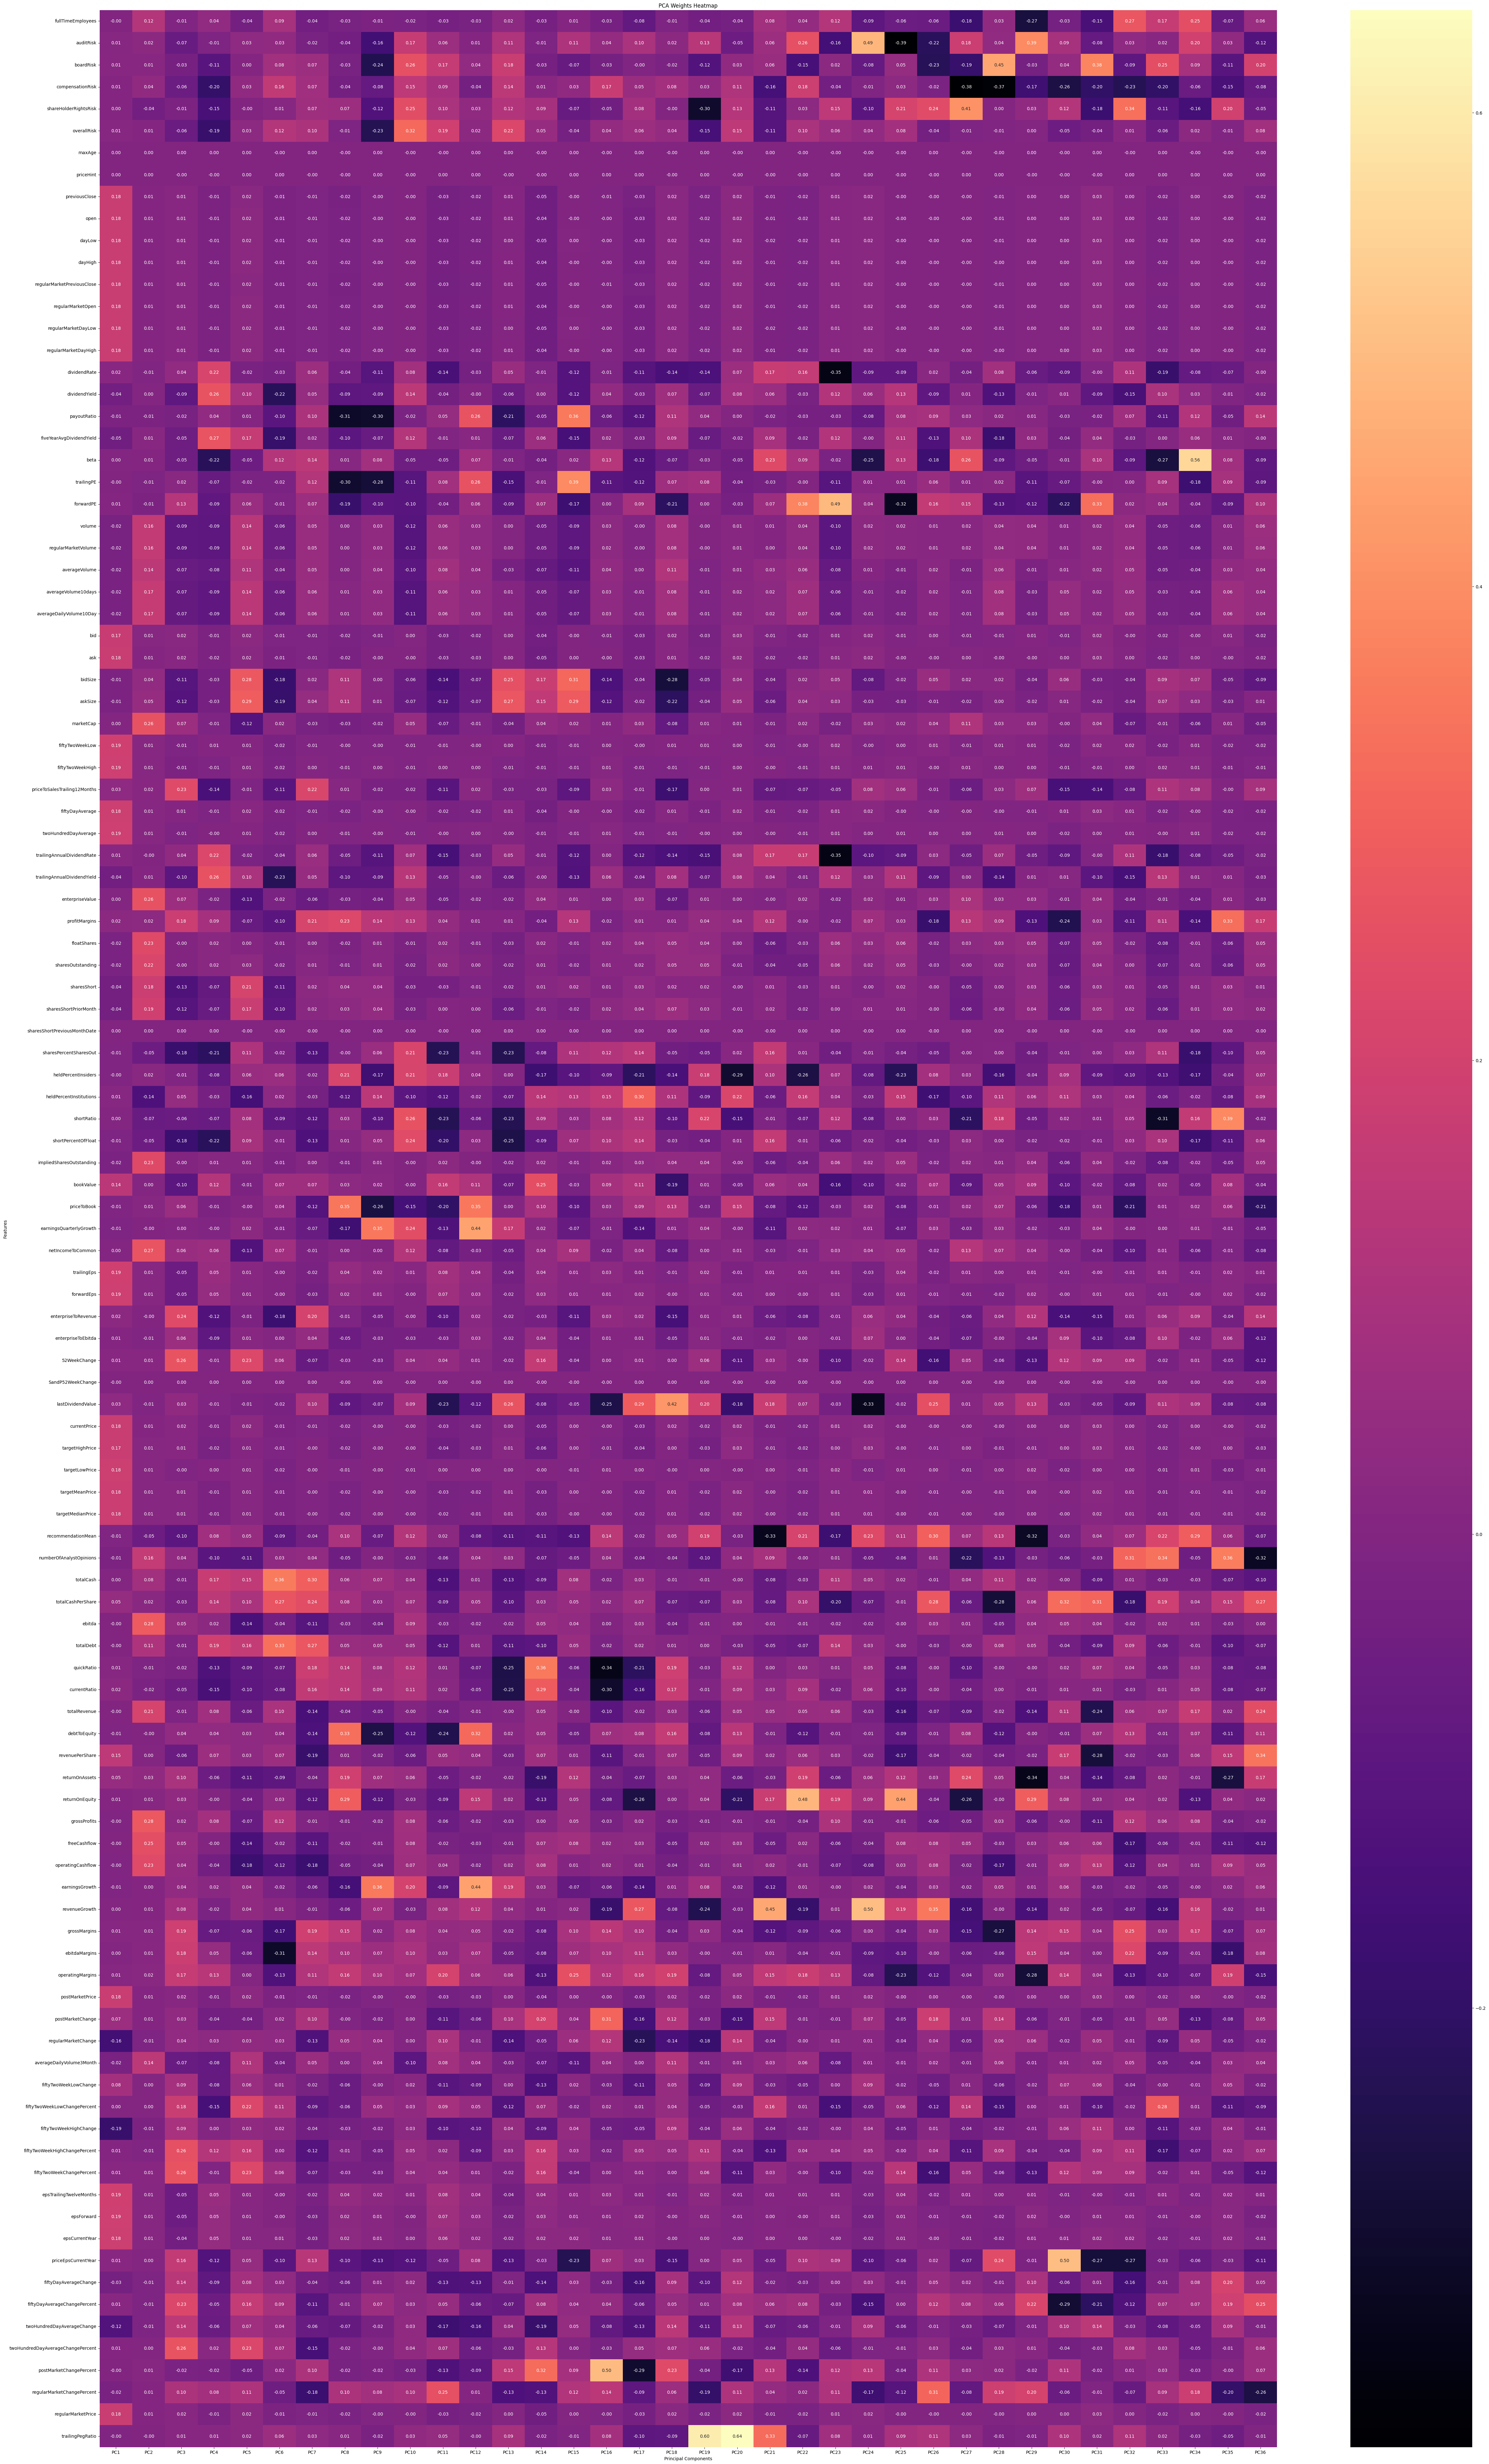

In [150]:
xLabels = []
for i in range(pcaWeightsDF.shape[1]):
    xLabels.append( "PC" + str(i+1)) ,
plt.figure(figsize=(60, 100))
#plt.subplots_adjust(left=0.1, right=0.15, top=0.15, bottom=0.1)
sns.heatmap(pcaWeightsDF, cmap= "magma", xticklabels= xLabels, yticklabels= pcaWeightsDF.index.tolist(), annot=True, fmt=".2f")
plt.ylabel("Features")
plt.xlabel("Principal Components")
plt.title("PCA Weights Heatmap")
plt.show()
#plt.savefig( "PCAWeightsHeatmap.png")


The component explaining the largest amiount of variance is listed first. The cumulative variance explained is shown below to a limit of 95%. 

The proportion of variance each component explains represents the amount of information from the original data that is captured in a given component.



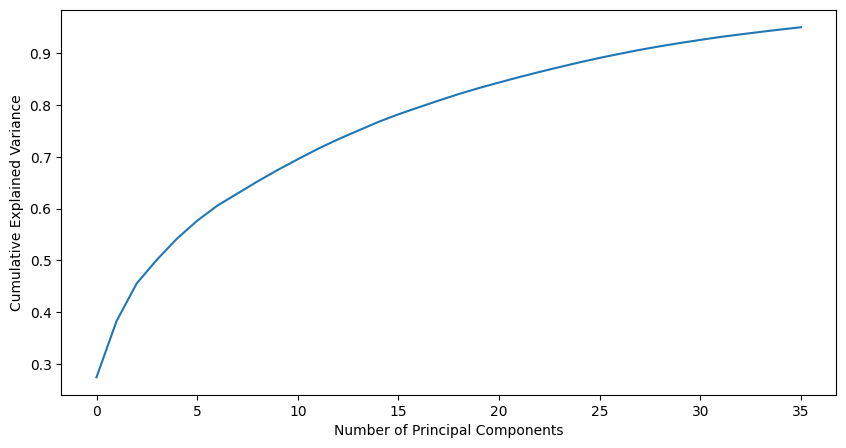

In [151]:
# Cumulative Explained variance:
# Plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
#plt.savefig( "PCACumVarPlot.png")

<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;"> Fit K-Means (Unsupervised Model), and Logistic Rgeression (Supervised):</h3>
We will first not use the labels we have, and fit a K-Means model to discover the 4 clusters [buy, strong buy, hold, underperform] that we know analyst use to rate stocks. Since we have the labels available, I will be able to measure a accuracy once the model is built. 
I will split the data set into training and testing sets, fit a K-Means model, fine tune hyperparameters, and compare the results to a supervised Logistic Regression Model.




Line295 Rs= 29109

Line 416 Supervised Learning Model: Logistic Regression. Confusion Matrix:
 [[71  2  1  0]
 [ 5 11  0  0]
 [ 1  0  1  0]
 [ 0  1  0  0]]

Line 417: Supervised LR Model accuracy (testing set) %= 89.25 %.

Line 424: Supervised LR Model mean Precision %: 55.19

Line 425: Supervised LR Model mean Recall %: 53.67


/home/lrt/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Line 392: Unsupervised KMeans Model Confusion Matrix:
 [[ 2  0 14  0]
 [ 0  1  1  0]
 [ 0  1 73  0]
 [ 0  0  1  0]]

Line 393: Unsupervised KMeans Model accuracy (testing set) %= 81.72 . 

Kmeans Unsupervised KMeans Model Recall %= [12.5, 50.0, 98.65, 0.0]

Line 402: Kmeans Unsupervised Model Recall %:  0.4

Line 429:
 
Training Set: 
bestAcc= 273 
bestAccPct= 73.39 
bestDic:
 {'buy': 2, 'strong_buy': 1, 'hold': 0, 'underperform': 3} 
bestCombi:
 (2, 1, 0, 3) 
bestRs:
 29109

Line 436:
 
Testing Set: 
bestAcc= 76 
bestAccPct= 81.72 
bestDic:
 {'buy': 2, 'strong_buy': 1, 'hold': 0, 'underperform': 3} 
bestCombi:
 (2, 1, 0, 3) 
bestRs:
 29109

Line443: Supervised LR model Testing Set accuracy %: 89.25 supModelBestRs= 29109


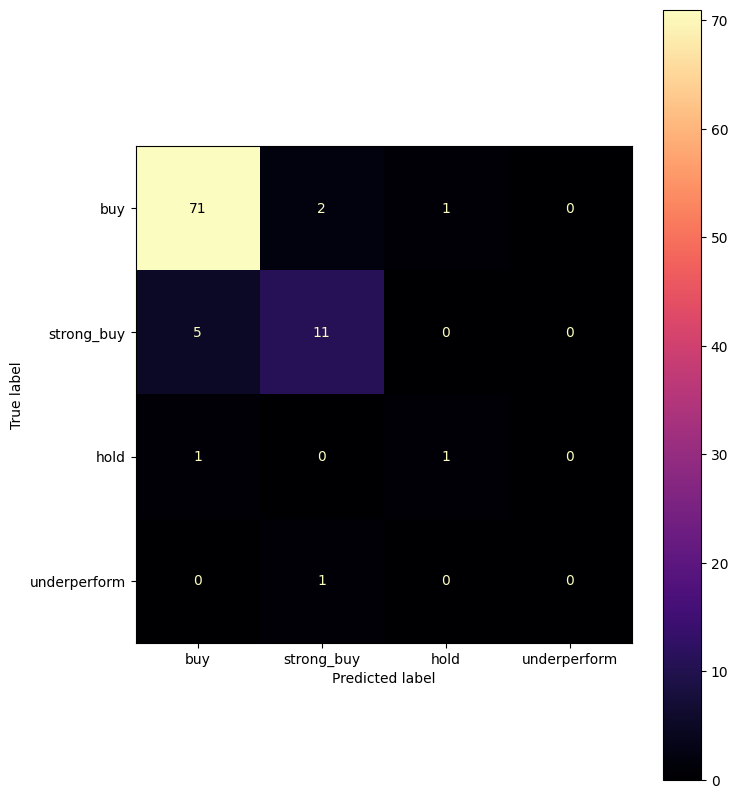

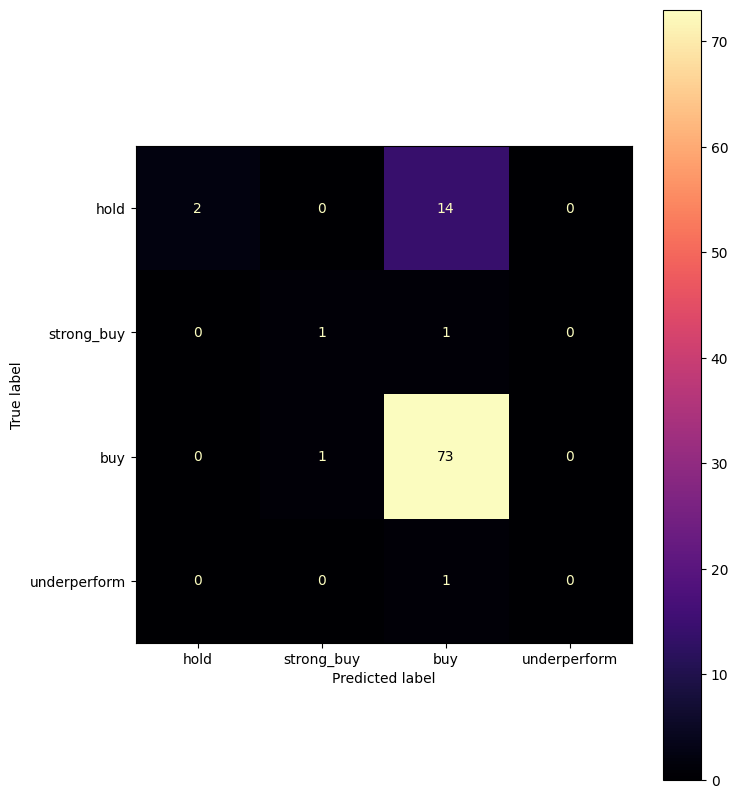

In [156]:
bestTrainAcc = 0
bestTrainDic = None
bestTrainCombi = None
bestTrainRs = 0
bestTrainAccPct = 0

bestTestAcc = 0
bestTestDic = None
bestTestCombi = None
bestTestRs = 0
bestTestAccPct = 0
bestRecKeyRealTest = None

supModelBestAccPct = 0
supModelBestRs = 0
for rs in range(1):
    rs=29109
    print("\nLine295 Rs=", rs)
    kmeans = KMeans(n_clusters=len(recKeys), random_state=rs, max_iter=10000, 
                    n_init="auto", init="k-means++", algorithm="elkan")

    #kmeans.fit(X_pca)
    kmeans.fit(pcaDFTransfTrain)

    # Predict cluster for training data:
    XTrainpca = pca.transform(pcaDFScaledTrain)
    #cluster_labels = kmeans.predict(X_new_pca)
    clustLabelsTrain = kmeans.predict(XTrainpca)
    
    # Predict cluster for testing data:
    XTestpca = pca.transform(pcaDFScaledTest)
    clustLabelsTest = kmeans.predict(XTestpca)

    #print(cluster_labels)
    #print(pcaFullCleanDF["recommendationKey"])

    # Numerical keys are assigned randomly.
    # There are 4 recommendation keys: buy, strong buy, hold, underperformed.
    # These keys will map to some combination of 0,1,2,3. There are 24 options.

    clusterNum = [0, 1, 2, 3]
    combiL = list(itertools.permutations(clusterNum))
    #print(combiL)

    recKeyDic = {"buy":0, "strong_buy":1, "hold":2, "underperform":3}
    recKeysL = list(recKeyDic.keys())

    recKeyTrain = list(yTrain.copy()) # original string recommendation buy, hold,.... 
    recKeyTest = list(yTest.copy()) # original string recommendation buy, hold,.... 
    
    for combi in combiL:
            # Build the dictionary for that combination:
            for i in range(len(combi)):
                    recKeyDic[recKeysL[i]] = combi[i]
            
            # Assign a numerical label to the original train string based on this combi sequence:
            recKeyRealTrain = [] # numerical version of the string.
            for j in range( len(recKeyTrain)):
                    tempTrainkey = recKeyTrain[j]
                    recKeyRealTrain.append(recKeyDic[tempTrainkey])
            # Evaluate the accuracy of this combination in the training set:
            tempTrainAcc = 0
            for k in range( len(recKeyTrain)):
                    if(recKeyRealTrain[k] == clustLabelsTrain[k]):
                            tempTrainAcc += 1
            if(tempTrainAcc > bestTrainAcc):
                    bestTrainAcc = tempTrainAcc
                    bestTrainDic = recKeyDic.copy()
                    bestTrainCombi = combi
                    bestTrainRs = rs
                    bestTrainAccPct = round(bestTrainAcc/len(recKeyTrain)*100,2)

            # Assign a numerical label to the original TEST string based on this combi sequence:
            recKeyRealTest = [] # numerical version of the string.
            for j in range( len(recKeyTest)):
                    tempTestkey = recKeyTest[j]
                    recKeyRealTest.append(recKeyDic[tempTestkey])
            # Evaluate the accuracy of this combination in the TEST set:
            tempTestAcc = 0
            for k in range( len(recKeyTest)):
                    if(recKeyRealTest[k] == clustLabelsTest[k]):
                            tempTestAcc += 1
            if(tempTestAcc > bestTestAcc):
                    bestTestAcc = tempTestAcc
                    bestTestDic = recKeyDic.copy()
                    bestTestCombi = combi
                    bestTestRs = rs
                    bestTestAccPct = round(bestTestAcc/len(recKeyTest)*100,2)
                    bestRecKeyRealTest = recKeyRealTest
            if (combi == combiL[ len(combiL)-1]): # if this is the last combination tested, print best results.
                    # Confusion Matrix and metrics on the test set:
                    confMatk = confusion_matrix(y_true = bestRecKeyRealTest, y_pred = clustLabelsTest)
                    accuracyk = accuracy_score(y_true = bestRecKeyRealTest, y_pred = clustLabelsTest)
                    recallk = recall_score(y_true = bestRecKeyRealTest, y_pred = clustLabelsTest, average = None)
                    #precisionk = precision_score(y_true = recKeyRealTest, y_pred = clustLabelsTest, average = None)
                    print("\nLine 392: Unsupervised KMeans Model Confusion Matrix:\n", confMatk)
                    print("\nLine 393: Unsupervised KMeans Model accuracy (testing set) %=", round(accuracyk*100,2), ". ")#,
                    #"\nRecall and precision calculated by category. \nCategories:\n", 
                    #"\nModel Precision =", precisionk,
                    print("\nKmeans Unsupervised KMeans Model Recall %=", [round(x,2) for x in recallk*100]) 

                    #precMeank = precisionk.mean()
                    recallMeank = recallk.mean()
                    #print("\nLine 398: Model mean Precision:", round(precisionk.mean(),2))
                    print("\nLine 402: Kmeans Unsupervised Model Recall %: ", round(recallk.mean(),2))

                    bestTestDicSorted = dict(sorted(bestTestDic.items(), key=lambda item: item[1]))
                    confMatKMeansDisplay = ConfusionMatrixDisplay(confMatk, display_labels = list(bestTestDicSorted.keys()))
                    figk, axk = plt.subplots(figsize=(8,10))
                    confMatKMeansDisplay.plot(ax=axk, cmap='magma')
                    figk.show
                    #figk.savefig("confMatKMeansModel.png")

            # SUPERVISED MODEL:
            #====================
            supModel = LogisticRegression(max_iter=10000, random_state=rs)
            supModel.fit(pcaDFTransfTrain, yTrain)
            yPred = supModel.predict(pcaDFTransfTest)
            supAccPct = round(accuracy_score(yTest, yPred) *100,2)
            if(supAccPct > supModelBestAccPct):
                    supModelBestAccPct = supAccPct
                    supModelBestRs = rs
                    # Confusion Matrix and metrics on the test set:
                    confMatSup = confusion_matrix(y_true = yTest, y_pred = yPred)
                    accuracySup = accuracy_score(y_true = yTest, y_pred = yPred)
                    recallSup = recall_score(y_true = yTest, y_pred = yPred, average = None)
                    precisionSup = precision_score(y_true = yTest, y_pred = yPred, average = None)
                    print("\nLine 416 Supervised Learning Model: Logistic Regression. Confusion Matrix:\n", confMatSup)
                    print("\nLine 417: Supervised LR Model accuracy (testing set) %=", round(accuracySup*100,2), "%."),
                    "\nRecall and precision calculated by category. \nCategories:\n", 
                    "\nSupervised LR Model Precision %=", [round(x,2) for x in precisionSup*100],
                    "\nSupervised LR Model Recall %=", [round(x,2) for x in recallSup*100]

                    precMeanSup = precisionSup.mean()
                    recallMeanSup = recallSup.mean()
                    print("\nLine 424: Supervised LR Model mean Precision %:", round(precisionSup.mean()*100,2))
                    print("\nLine 425: Supervised LR Model mean Recall %:", round(recallSup.mean()*100,2))

                    confMatSupDisplay = ConfusionMatrixDisplay(confMatSup, display_labels = recKeysL)
                    figSup, axSup = plt.subplots(figsize=(8,10))
                    confMatSupDisplay.plot(ax=axSup, cmap='magma')
                    figSup.show
                    #figSup.savefig("confMatSupLRModel.png")

print( "\nLine 429:\n", "\nTraining Set: \nbestAcc=", bestTrainAcc, "\nbestAccPct=", bestTrainAccPct, "\nbestDic:\n", bestTrainDic, "\nbestCombi:\n", bestTrainCombi, "\nbestRs:\n", bestTrainRs)

print( "\nLine 436:\n", "\nTesting Set: \nbestAcc=", bestTestAcc, "\nbestAccPct=", bestTestAccPct,"\nbestDic:\n", bestTestDic, "\nbestCombi:\n", bestTestCombi, "\nbestRs:\n", bestTestRs)

print("\nLine443: Supervised LR model Testing Set accuracy %:", supModelBestAccPct, "supModelBestRs=", supModelBestRs)





<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Conclussions and Final Comments:</h3>
The confusion matrices for the K-Means (Unsupervised) and Logistic Regression (LR) (Supervised) are presented above. The K-Means unsupervised method finds the four clusters with 82% accuracy. While this is perhpas a bit low a threshhold to issue a sound recommendation, I find this an amazing result. In the absence of anything else but this data set, we would be able to make an informed, better, decision if faced with the question of rating a security. The supervised LR method does even better, wuth almost 90% accuracy. 

Dimensionality reduction through PCA was an important step to be able to get the algorithms to deliver results in reasonable time.


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  Future Developments:</h3>

The SP500 list of stocks is about 10% of the total of 6000 securities in the US, and a small fraction of all securities listed worldwide. 

Future extensions of this work would include all US stocks first with international markets added progressively.


<h3 style="font-weight: bold; font-style: italic; text-decoration: underline;">  List of References:</h3>

https://pypi.org/project/yfinance/

https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/

https://github.com/shilewenuw/get_all_tickers/blob/master/get_all_tickers/get_tickers.py

https://www.geeksforgeeks.org/principal-component-analysis-pca/













